# Градиентный бустинг

градиентный бустинг (gradient boosting machine) является одним из основных production-решений при работе с табличными, неоднородными данными, поскольку обладает высокой производительностью и точностью

Выбранные для этой базы данных признаки получены из акселерометра и гироскопа, обеспечивающих сырые сигналы по трем осям tAcc-XYZ и tGyro-XYZ. Эти сигналы временной области (префикс 't' обозначает время) были захвачены с постоянной частотой 50 Гц. Затем они были отфильтрованы с использованием медианного фильтра и низкочастотного фильтра Баттерворта 3-го порядка с частотой среза 20 Гц для удаления шума. Аналогично, сигнал ускорения был затем разделен на сигналы ускорения тела и ускорения гравитации (tBodyAcc-XYZ и tGravityAcc-XYZ) с использованием другого низкочастотного фильтра Баттерворта с частотой среза 0.3 Гц.

Затем линейное ускорение тела и угловая скорость были дифференцированы по времени для получения сигналов толчка (Jerk) (tBodyAccJerk-XYZ и tBodyGyroJerk-XYZ). Также величина этих трехмерных сигналов была рассчитана с использованием евклидовой нормы (tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag).

Наконец, к некоторым из этих сигналов было применено быстрое преобразование Фурье (FFT), что привело к созданию сигналов fBodyAcc-XYZ, fBodyAccJerk-XYZ, fBodyGyro-XYZ, fBodyAccJerkMag, fBodyGyroMag, fBodyGyroJerkMag. (Примечание: 'f' указывает на сигналы частотной области).

Эти сигналы использовались для оценки переменных вектора признаков для каждого шаблона:
'-XYZ' используется для обозначения трехосевых сигналов в направлениях X, Y и Z.

tBodyAcc-XYZ tGravityAcc-XYZ tBodyAccJerk-XYZ tBodyGyro-XYZ tBodyGyroJerk-XYZ tBodyAccMag tGravityAccMag tBodyAccJerkMag tBodyGyroMag tBodyGyroJerkMag fBodyAcc-XYZ fBodyAccJerk-XYZ fBodyGyro-XYZ fBodyAccMag fBodyAccJerkMag fBodyGyroMag fBodyGyroJerkMag

Набор переменных, оцененных на основе этих сигналов, включает:

mean(): Среднее значение std(): Стандартное отклонение mad(): Медианное абсолютное отклонение max(): Максимальное значение в массиве min(): Минимальное значение в массиве sma(): Площадь сигнала energy(): Мера энергии. Сумма квадратов, деленная на количество значений. iqr(): Интерквартильный размах entropy(): Энтропия сигнала arCoeff(): Коэффициенты авторегрессии с порядком Бурга, равным 4 correlation(): Коэффициент корреляции между двумя сигналами maxInds(): Индекс компоненты частоты с наибольшей амплитудой meanFreq(): Взвешенное среднее частотных компонентов для получения средней частоты skewness(): Ассиметрия сигнала в частотной области kurtosis(): Экцесс сигнала в частотной области bandsEnergy(): Энергия частотного интервала в пределах 64 бинов FFT каждого окна. angle(): Угол между двумя векторами.

Дополнительные векторы, полученные путем усреднения сигналов в образце окна сигнала. Они используются для переменной angle():

gravityMean tBodyAccMean tBodyAccJerkMean tBodyGyroMean tBodyGyroJerkMean  




In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from typing import Type



In [2]:
!ls

1. Data.xlsx                        SVM.ipynb
1. Lab 1. Dataset_info.ipynb        association_rule.ipynb
ARL(apriori, fpg).ipynb             boosting.ipynb
Chemical Composion of Ceramic.csv   raw_dataset.pkl
Clustering.ipynb                    ~$Online Retail.xlsx
HAR_dataset                         Без названия-Copy1.ipynb
MLP.ipynb                           Без названия.ipynb
Online Retail.xlsx


In [48]:
path = './HAR_dataset/UCI HAR Dataset'

with open(f'{path}/features.txt') as f:
    column_names = [line.strip().split(' ', 1)[1] for line in f]

with open(f'{path}/train/X_train.txt') as f:
    X_train = pd.DataFrame(list(map(lambda el: list(map(float, el.split())), f.read().split('\n')))[:-1],
                           columns = column_names)

with open(f'{path}/train/y_train.txt') as f:
    y_train = pd.DataFrame(list(map(lambda el: list(map(float, el.split())), f.read().split('\n')))[:-1])

with open(f'{path}/test/X_test.txt') as f:
    X_test = pd.DataFrame(list(map(lambda el: list(map(float, el.split())), f.read().split('\n')))[:-1],
                         columns = column_names)

with open(f'{path}/test/y_test.txt') as f:
    y_test = pd.DataFrame(list(map(lambda el: list(map(float, el.split())), f.read().split('\n')))[:-1])

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
X_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [14]:
y_train.nunique() 

0    6
dtype: int64

имеем задачу классификации по 6 состояниям WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING в y

в x имеем 560 признаков

In [ ]:
Сделаем подбор параметров на библиотечеом методе GradientBoostingClassifier, тк его fit на моей машине составляет около 1-3 мин
Вот без каких либо предположений о датасете возьмем сетку, который содержат некие best practicies параметры у GBC 
имеем где-то 400 фитов, благо у меня 14 воркеров 

In [1]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
 
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200], #количество деревьев что будем строить для снисхождения от оригинальной вероятности отнесения класса
    'learning_rate': [0.01, 0.1, 0.2], #множитель при обучении для нового дерева
    'max_depth': [3, 6, 9], #глубина разбиения
    'min_samples_leaf': [5, 10, 50], #минимальное количество сэмлов в листе -  конечном ноде
    'min_samples_split': [10, 50, 100] #минимальное количество сэмлов в ноде для разбиения This should be ~0.5-1% of total values - наверное мне надо было взять 350 и 700 еще
}
 
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
 
# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)
 
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
 
# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

NameError: name 'X_train' is not defined

In [2]:
#3 часа спустя у меня прервался kernel зато я изучил какие параметры тут лучше встанут и проведу лучший 

In [ ]:
# max_depth and min_samples_split have a significant impact and we’re tuning those first.

In [16]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
 
# Define the parameter grid for GridSearchCV
param_grid = {
    'min_samples_leaf': [200, 500], #минимальное количество сэмлов в листе -  конечном ноде
    'min_samples_split': [300, 500, 700] #минимальное количество сэмлов в ноде для разбиения This should be ~0.5-1% of total values - наверное мне надо было взять 350 и 700 еще
}
 
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
 
# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)
 
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
 
# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:11

Best Parameters: {'min_samples_leaf': 500, 'min_samples_split': 300}
Best Model Accuracy: 0.9504580929759077


Ок теперь мы знаем параметры для дерева перейдем к параметрам бустинга, немного поиграв, расширив границы параметров дерева

In [17]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200], #количество деревьев что будем строить для снисхождения от оригинальной вероятности отнесения класса
    'learning_rate': [0.1, 0.3], #множитель при обучении для нового дерева
    'max_depth': [5, 7, 9], #глубина разбиения
    'min_samples_leaf': [500, 700], #минимальное количество сэмлов в листе -  конечном ноде
    'min_samples_split': [200, 300] #минимальное количество сэмлов в ноде для разбиения This should be ~0.5-1% of total values - наверное мне надо было взять 350 и 700 еще
}
 
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
 
# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)
 
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
 
# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:11

Best Parameters: {'learning_rate': 0.3, 'max_depth': 9, 'min_samples_leaf': 500, 'min_samples_split': 200, 'n_estimators': 200}
Best Model Accuracy: 0.9572446555819477


Еще 4.5 часа спустя мы имеем очередной результат грид серча гиперпараметров
Теперь уменьшим число экспериментов для каждой комбы до 2 и проверим новые границы

In [19]:
param_grid = {
    'n_estimators': [200, 300], #количество деревьев что будем строить для снисхождения от оригинальной вероятности отнесения класса
    'learning_rate': [0.3, 0.4], #множитель при обучении для нового дерева
    'max_depth': [9, 12], #глубина разбиения
    'min_samples_leaf': [350, 500], #минимальное количество сэмлов в листе -  конечном ноде
    'min_samples_split': [150, 200] #минимальное количество сэмлов в ноде для разбиения This should be ~0.5-1% of total values - наверное мне надо было взять 350 и 700 еще
}
 
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)
 
# Fit the model to the training data using GridSearchCV
grid_search.fit(X_train, y_train)
 
# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)
 
# Evaluate the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
 
# Print the results
print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/vladimirnikitin/miniconda3/envs/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:11

Best Parameters: {'learning_rate': 0.3, 'max_depth': 9, 'min_samples_leaf': 350, 'min_samples_split': 200, 'n_estimators': 200}
Best Model Accuracy: 0.9457074991516796


так как мы сдвинулись с границ древесных параметров - наблюдаем ухудшение точности и потерю контроля над экспериментом - возвращаемся к значениям предыдущих параметров и используем их

In [27]:
print(round_predictions(y_pred))

['LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'STANDING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'STANDING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'STANDING', 'LAYING', 'LAYING', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WA

Хорошо, посмотрели как работает библиотечный метод и посмотрели с чем придется работать - напишем код вручную


In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

class GradientBoostingClassifierFromScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1, min_samples_leaf=1, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.n_classes = np.max(y) + 1
        y_ohe = self._one_hot_encode_labels(y)
        print(y)
        print(y_ohe)
        raw_predictions = np.zeros((X.shape[0], self.n_classes))
        self.boosters = []
        for m in range(self.n_estimators):
            probabilities = self._softmax(raw_predictions)
            class_trees = []
            for k in range(self.n_classes):
                negative_gradients = self._negative_gradients(y_ohe[:, k], probabilities[:, k])
                tree = DecisionTreeClassifier(
                    max_depth=self.max_depth,
                    min_samples_leaf=self.min_samples_leaf,
                    min_samples_split=self.min_samples_split
                )
                tree.fit(X, np.sign(negative_gradients))
                self._update_terminal_nodes(tree, X, negative_gradients)
                raw_predictions[:, k] += self.learning_rate * tree.predict_proba(X)[:, 0]
                class_trees.append(tree)
            self.boosters.append(class_trees)

    def _one_hot_encode_labels(self, y):
        num_classes = np.max(y) + 1
        y_ohe = np.eye(num_classes)[y]
        return y_ohe

    def _negative_gradients(self, y_ohe, probabilities):
        return y_ohe - probabilities

    def _softmax(self, raw_predictions):
        return softmax(raw_predictions, axis=1)

    def _update_terminal_nodes(self, tree, X, negative_gradients):
        leaf_nodes = np.nonzero(tree.tree_.children_left == -1)[0]
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            if len(samples_in_this_leaf) == 0:
                continue
            negative_gradients_in_leaf = negative_gradients.take(samples_in_this_leaf, axis=0)
            val = np.mean(negative_gradients_in_leaf)
            tree.tree_.value[leaf, 0, 0] = val

    def predict_proba(self, X):
        raw_predictions = np.zeros((X.shape[0], self.n_classes))
        for m in range(self.n_estimators):
            for k in range(self.n_classes):
                raw_predictions[:, k] += self.learning_rate * self.boosters[m][k].predict_proba(X)[:, 0]
        probabilities = self._softmax(raw_predictions)
        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    def compute_roc_auc(self, y_true, y_scores):
        thresholds = np.sort(np.unique(y_scores))
        tpr_list = []
        fpr_list = []

        for threshold in thresholds:
            y_pred = (y_scores >= threshold).astype(int)
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)

        tpr = np.array(tpr_list)
        fpr = np.array(fpr_list)
        auc = np.trapz(tpr, fpr)
        
        # Plotting the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        return fpr, tpr, auc

In [23]:
### Прописываем параметры для нашей модели 
params = {'learning_rate': 0.3,
          'max_depth': 9,
          'n_estimators': 200
         }

In [74]:
### Прописываем параметры для нашей модели 
params = {'learning_rate': 0.3,
          'max_depth': 9,
          'min_samples_leaf': 350,
          'min_samples_split': 200,
          'n_estimators': 200
         }

In [52]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [55]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [131]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train

array([4, 4, 4, ..., 1, 1, 1])

In [133]:
gbcfs = GradientBoostingClassifierFromScratch(**params)
gbcfs.fit(X_train, y_train)

[4 4 4 ... 1 1 1]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [134]:
res = (gbcfs.predict(X_test))
print(res[:100])
y_test[:100]

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4
 4 4 4 4 4 4 4 3 4 4 4 4 3 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [138]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, gbcfs.predict(X_test))

0.827960637936885

In [140]:
y_test_scores = gbcfs.predict(X_test)

fpr, tpr, auc = gbcfs.compute_roc_auc(y_test, y_test_scores)

print(f"ROC AUC: {auc}")

ROC AUC: -0.8146659475378398


In [148]:
params = {'learning_rate': 0.3,
          'max_depth': 9,
          'min_samples_leaf': 50,
          'min_samples_split': 100,
          'n_estimators': 100
         }
gbcfs2 = GradientBoostingClassifierFromScratch(**params)
gbcfs2.fit(X_train, y_train)

[4 4 4 ... 1 1 1]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [149]:
accuracy_score(y_test, gbcfs2.predict(X_test))

0.8473023413640991

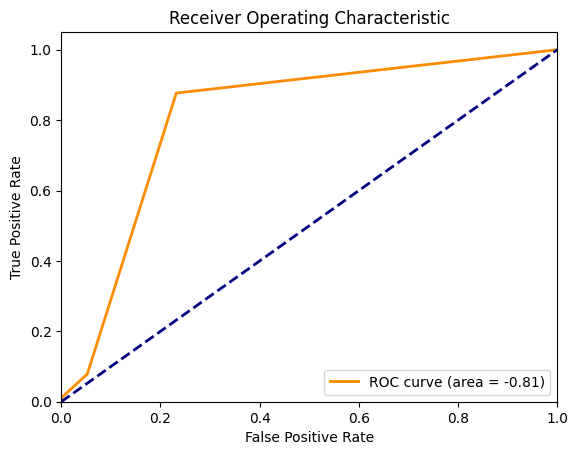

ROC AUC: 0.8089043558660366


In [152]:
y_test_scores = gbcfs2.predict(X_test)

fpr, tpr, auc = gbcfs2.compute_roc_auc(y_test, y_test_scores)

print(f"ROC AUC: {-auc}")

In [153]:
params = {'learning_rate': 0.1,
          'max_depth': 7,
          'min_samples_leaf': 50,
          'min_samples_split': 100,
          'n_estimators': 200
         }
gbcfs3 = GradientBoostingClassifierFromScratch(**params)
gbcfs3.fit(X_train, y_train)

[4 4 4 ... 1 1 1]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


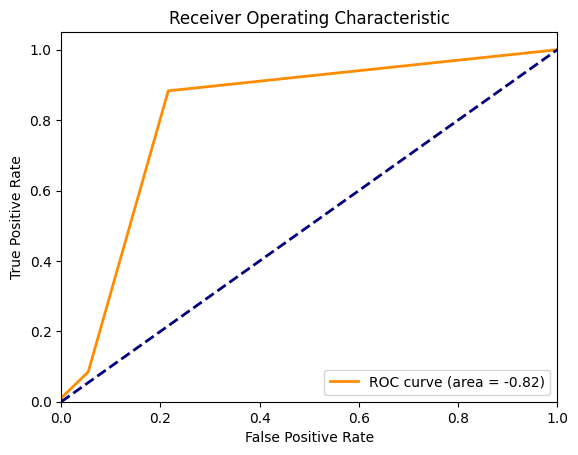

ROC AUC: 0.8191605027052943


In [154]:
y_test_scores = gbcfs3.predict(X_test)

fpr, tpr, auc = gbcfs3.compute_roc_auc(y_test, y_test_scores)

print(f"ROC AUC: {-auc}")

In [155]:
accuracy_score(y_test, y_test_scores)

0.8523922633186292

In [156]:
true_positives = sum((true == 1) and (pred == 1) for true, pred in zip(y_test, y_test_scores))
predicted_positives = sum(pred == 1 for pred in y_test_scores)
actual_positives = sum(true == 1 for true in y_test)

precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Вывод метрик
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.7611336032388664
Recall: 0.7983014861995754
F1-score: 0.7792746113989638


In [161]:
y_test_scores[:294]

array([4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [167]:
class SimpleDecisionTree:
    def __init__(self, max_depth=1, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:
            return np.mean(y)
        
        best_split = self._find_best_split(X, y)
        if not best_split:
            return np.mean(y)
        
        left_indices, right_indices = self._split(X[:, best_split['feature']], best_split['threshold'])
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {'feature': best_split['feature'], 'threshold': best_split['threshold'], 'left': left_subtree, 'right': right_subtree}

    def _find_best_split(self, X, y):
        best_split = {}
        best_mse = float('inf')
        n_samples, n_features = X.shape
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices, right_indices = self._split(X[:, feature], threshold)
                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue
                
                mse = self._calculate_mse(y[left_indices], y[right_indices])
                if mse < best_mse:
                    best_mse = mse
                    best_split = {'feature': feature, 'threshold': threshold}
        
        return best_split if best_split else None

    def _split(self, feature_column, threshold):
        left_indices = np.where(feature_column <= threshold)[0]
        right_indices = np.where(feature_column > threshold)[0]
        return left_indices, right_indices

    def _calculate_mse(self, left_y, right_y):
        left_mse = np.var(left_y) * len(left_y)
        right_mse = np.var(right_y) * len(right_y)
        return left_mse + right_mse

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):
            feature, threshold = tree['feature'], tree['threshold']
            if sample[feature] <= threshold:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree

In [168]:
class GradientBoostingClassifierFromScratch1:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=1, min_samples_leaf=1, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.n_classes = np.max(y) + 1
        y_ohe = self._one_hot_encode_labels(y)
        raw_predictions = np.zeros((X.shape[0], self.n_classes))
        self.boosters = []
        for m in range(self.n_estimators):
            probabilities = self._softmax(raw_predictions)
            class_trees = []
            for k in range(self.n_classes):
                negative_gradients = self._negative_gradients(y_ohe[:, k], probabilities[:, k])
                tree = SimpleDecisionTree(
                    max_depth=self.max_depth,
                    min_samples_leaf=self.min_samples_leaf,
                    min_samples_split=self.min_samples_split
                )
                tree.fit(X, negative_gradients)
                self._update_terminal_nodes(tree, X, negative_gradients)
                raw_predictions[:, k] += self.learning_rate * tree.predict(X)
                class_trees.append(tree)
            self.boosters.append(class_trees)


    def _one_hot_encode_labels(self, y):
        num_classes = np.max(y) + 1
        y_ohe = np.eye(num_classes)[y]
        return y_ohe

    def _negative_gradients(self, y_ohe, probabilities):
        return y_ohe - probabilities

    def _softmax(self, raw_predictions):
        return softmax(raw_predictions, axis=1)

    def _update_terminal_nodes(self, tree, X, negative_gradients):
        def update_tree(node, X, negative_gradients):
            if isinstance(node, dict):
                feature, threshold = node['feature'], node['threshold']
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold
                update_tree(node['left'], X[left_indices], negative_gradients[left_indices])
                update_tree(node['right'], X[right_indices], negative_gradients[right_indices])
            else:
                node = np.mean(negative_gradients)

        update_tree(tree.tree, X, negative_gradients)

    def predict_proba(self, X):
        raw_predictions = np.zeros((X.shape[0], self.n_classes))
        for m in range(self.n_estimators):
            for k in range(self.n_classes):
                raw_predictions[:, k] += self.learning_rate * self.boosters[m][k].predict_proba(X)[:, 0]
        probabilities = self._softmax(raw_predictions)
        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    def compute_roc_auc(self, y_true, y_scores):
        thresholds = np.sort(np.unique(y_scores))
        tpr_list = []
        fpr_list = []

        for threshold in thresholds:
            y_pred = (y_scores >= threshold).astype(int)
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)

        tpr = np.array(tpr_list)
        fpr = np.array(fpr_list)
        auc = np.trapz(tpr, fpr)
        
        # Plotting the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        return fpr, tpr, auc

In [ ]:
params = {'learning_rate': 0.3,
          'max_depth': 9,
          'min_samples_leaf': 50,
          'min_samples_split': 100,
          'n_estimators': 100
         }
gbcfs4 = GradientBoostingClassifierFromScratch1(**params)
gbcfs4.fit(X_train, y_train)

In [ ]:
y_test_scores = gbcfs4.predict(X_test)

fpr, tpr, auc = gbcfs4.compute_roc_auc(y_test, y_test_scores)

print(f"ROC AUC: {-auc}")

true_positives = sum((true == 1) and (pred == 1) for true, pred in zip(y_test, y_test_scores))
predicted_positives = sum(pred == 1 for pred in y_test_scores)
actual_positives = sum(true == 1 for true in y_test)

precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Вывод метрик
print("Accuracy:", accuracy_score(y_test, y_test_scores))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_test_scores))
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)